# Coursework final

- Andy Yuan
- Aidan Dignam
- Amelia Walker
- Owen Stevenson


# Question 1

In [15]:
# Imports

import numpy as np
import polars as pl
import pandas as pd

# Clustering
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering, MiniBatchKMeans

# Dimensionality reduction
from sklearn.decomposition import PCA, SparsePCA, TruncatedSVD
from sklearn.manifold import TSNE

# Tree-based models
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor

# Model selection and evaluation
from sklearn.model_selection import (
    GridSearchCV, train_test_split, StratifiedKFold, cross_val_score, 
    cross_validate, RepeatedKFold
)

from sklearn.metrics import (
    silhouette_samples, silhouette_score, confusion_matrix, 
    roc_curve, roc_auc_score, classification_report, accuracy_score, r2_score
)

# Preprocessing and feature selection
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector

# Linear models
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import linear_model

# XGBoost
from xgboost import XGBRegressor, XGBClassifier

# Shap
import shap
shap.initjs() # Import Java engine.

# Plotting
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Statistical and optimization tools
from scipy.sparse import csr_matrix
from scipy.stats import zscore
from scipy.special import factorial
import scipy.optimize as so

# Text processing
import sklearn.feature_extraction.text as sktext
import re

# Dimensionality reduction
import umap

# Miscellaneous
import os
from itertools import chain, combinations
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer
import heapq


In [16]:
householdspend = pl.read_csv("../Coursework Data/HouseholdSpend.csv")
demographics = pl.read_csv("../Coursework Data/DemoStats.csv")

In [17]:
# Combine data on the CODE variable
data_combined = householdspend.join(demographics, on="CODE", how="full")

# Dropping columns described in the Discord announcements
columns_to_drop = ["HSHNIAGG", "HSAGDISPIN", "HSAGDISCIN", 
                   "HSEP001", "HSEP002", "HSEP003", "HSEP004", "HSEP005", "HSEP006", "HSEP007", 
                   "CODE", "CODE_right", "GEO", "GEO_right"]
ifexisting_cols = [col for col in columns_to_drop if col in data_combined.columns]
datahouseholds = data_combined.drop(ifexisting_cols)
datahouseholds.describe()

statistic,HSBASHHD,HSTT001,HSTE001,HSTX001,HSTC001,HSSH001S,HSFD001S,HSHO001S,HSHC001S,HSHF001S,HSTR001S,HSRE001S,HSPC001S,HSCL001S,HSED002S,HSRO001S,HSTA001S,HSGC001S,HSME001S,HSEP001S,HSMG001S,HSTE001ZBS,HSWH002S,HSWH028S,HSWH040S,HSWH041S,HSWH042S,HSSH001,HSSH002,HSSH003,HSSH004,HSSH053,HSSH054,HSSH005,HSSH006,HSSH007,…,ECYRIMINDI,ECYRIMNEPA,ECYRIMPAKI,ECYRIMSRI,ECYRIMSASO,ECYRIMOCE,ECYRIMAUSS,ECYRIMOCEO,ECYPIMHPOP,ECYPIMNI,ECYPIMIM,ECYPIMP01,ECYPIM0110,ECYPIM1115,ECYPIM1621,ECYPIM22CY,ECYPIMNPER,ECYAIMHPOP,ECYAIMNI,ECYAIMIM,ECYAIM_0_5,ECYAIM_514,ECYAIM1524,ECYAIM2544,ECYAIM45P,ECYAIMNPER,ECYGENHPOP,ECYGEN1GEN,ECYGEN2GEN,ECYGEN3GEN,ECYTCAHPOP,ECYTCACIT,ECYTCA_U18,ECYTCA_18P,ECYNCANCIT,ECYNCA_U18,ECYNCA_18P
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,…,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",18.432629,2.4008e6,2.1917e6,421335.834661,1.6065e6,388812.651163,278016.994627,111401.557243,109343.827301,76103.411113,271135.371662,87929.804561,45315.650319,70798.452452,34398.504565,3570.867859,70468.350013,25849.158365,33310.372386,115213.19111,48732.91062,209040.481816,67544.21004,4806.924846,112565.256385,15089.24985,9034.840695,388812.651163,303764.492909,89251.190609,88053.450315,87440.075786,613.374529,183.700577,828.596641,185.443075,…,0.477122,0.005692,0.038764,0.008754,0.00028,0.007272,0.005106,0.002166,45.881762,31.717238,11.757474,4.721479,2.368195,1.391643,1.640656,1.635501,2.407051,45.881762,31.717238,11.757474,1.066154,2.036562,2.230265,5.299374,1.125119,2.407051,45.881762,14.168175,7.448384,24.265204,45.881762,40.528679,7.761493,32.767185,5.353084,0.85628,4.496803
"""std""",69.379951,9.1329e6,8.0562e6,1.5969e6,5.9255e6,1.3661e6,1.0471e6,420881.63654,429642.774397,290959.592849,1.0751e6,327376.60947,163377.943862,249311.269506,114999.916794,14386.745375,264786.580294,94955.831503,127397.296924,431645.982804,206454.726959,1.2713e6,341440.420828,40531.631801,898861.389623,51492.602769,35858.838458,1.3661e6,1.0270e6,292325.224526,287942.333453,285952.018412,2371.573942,993.000184,3140.51177,1269.469849,…,2.516032,0.123928,0.364373,0.142995,0.02439,0.118581,0.094428,0.057987,171.817976,149.721097,32.868441,14.28478,7.28958,4.605282,5.813031,5.761745,10.479555,171.817976,149.721097,32.868441,3.400699,6.112712,6.550715,14.905824,3.936661,10.479555,171.817976,40.185434,24.588753,131.818196,171.817976,163.866165,34.782061,130.449848,17.893635,3.211073,15.020402
"""min""",0.0,-24249.492537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.4599e7,0.0,0.0,-1.6806e7,-26676.98553,-204380.698719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",3.0,288995.986572,265546.050861,3315

In [18]:
# identify which columns are strings
string_columns = datahouseholds.select(pl.col(pl.Utf8())).columns

# Replace NA with median values of the columns converted to string
for col in string_columns:
    median = (
        datahouseholds[col].replace("NA", None)
        .cast(pl.Float64)
        .median()
    )
    datahouseholds = datahouseholds.with_columns(
        pl.col(col).replace("NA", None)
        .cast(pl.Float64)
        .fill_null(median)
        .alias(col)
    )

In [19]:
string_columns = datahouseholds.select(pl.col(pl.Utf8())).columns
datahouseholds_cleaned = datahouseholds.with_columns(
    pl.col(string_columns).cast(pl.Float64)
)
datahouseholds_cleaned.describe()

statistic,HSBASHHD,HSTT001,HSTE001,HSTX001,HSTC001,HSSH001S,HSFD001S,HSHO001S,HSHC001S,HSHF001S,HSTR001S,HSRE001S,HSPC001S,HSCL001S,HSED002S,HSRO001S,HSTA001S,HSGC001S,HSME001S,HSEP001S,HSMG001S,HSTE001ZBS,HSWH002S,HSWH028S,HSWH040S,HSWH041S,HSWH042S,HSSH001,HSSH002,HSSH003,HSSH004,HSSH053,HSSH054,HSSH005,HSSH006,HSSH007,…,ECYRIMINDI,ECYRIMNEPA,ECYRIMPAKI,ECYRIMSRI,ECYRIMSASO,ECYRIMOCE,ECYRIMAUSS,ECYRIMOCEO,ECYPIMHPOP,ECYPIMNI,ECYPIMIM,ECYPIMP01,ECYPIM0110,ECYPIM1115,ECYPIM1621,ECYPIM22CY,ECYPIMNPER,ECYAIMHPOP,ECYAIMNI,ECYAIMIM,ECYAIM_0_5,ECYAIM_514,ECYAIM1524,ECYAIM2544,ECYAIM45P,ECYAIMNPER,ECYGENHPOP,ECYGEN1GEN,ECYGEN2GEN,ECYGEN3GEN,ECYTCAHPOP,ECYTCACIT,ECYTCA_U18,ECYTCA_18P,ECYNCANCIT,ECYNCA_U18,ECYNCA_18P
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,…,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0,868970.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",18.432629,2.4008e6,2.1917e6,421335.834661,1.6065e6,388812.651163,278016.994627,111401.557243,109343.827301,76103.411113,271135.371662,87929.804561,45315.650319,70798.452452,34398.504565,3570.867859,70468.350013,25849.158365,33310.372386,115213.19111,48732.91062,209040.481816,67544.21004,4806.924846,112565.256385,15089.24985,9034.840695,388812.651163,303764.492909,89251.190609,88053.450315,87440.075786,613.374529,183.700577,828.596641,185.443075,…,0.477122,0.005692,0.038764,0.008754,0.00028,0.007272,0.005106,0.002166,45.881762,31.717238,11.757474,4.721479,2.368195,1.391643,1.640656,1.635501,2.407051,45.881762,31.717238,11.757474,1.066154,2.036562,2.230265,5.299374,1.125119,2.407051,45.881762,14.168175,7.448384,24.265204,45.881762,40.528679,7.761493,32.767185,5.353084,0.85628,4.496803
"""std""",69.379951,9.1329e6,8.0562e6,1.5969e6,5.9255e6,1.3661e6,1.0471e6,420881.63654,429642.774397,290959.592849,1.0751e6,327376.60947,163377.943862,249311.269506,114999.916794,14386.745375,264786.580294,94955.831503,127397.296924,431645.982804,206454.726959,1.2713e6,341440.420828,40531.631801,898861.389623,51492.602769,35858.838458,1.3661e6,1.0270e6,292325.224526,287942.333453,285952.018412,2371.573942,993.000184,3140.51177,1269.469849,…,2.516032,0.123928,0.364373,0.142995,0.02439,0.118581,0.094428,0.057987,171.817976,149.721097,32.868441,14.28478,7.28958,4.605282,5.813031,5.761745,10.479555,171.817976,149.721097,32.868441,3.400699,6.112712,6.550715,14.905824,3.936661,10.479555,171.817976,40.185434,24.588753,131.818196,171.817976,163.866165,34.782061,130.449848,17.893635,3.211073,15.020402
"""min""",0.0,-24249.492537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.4599e7,0.0,0.0,-1.6806e7,-26676.98553,-204380.698719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",3.0,288995.986572,265546.050861,3315

In [20]:
data = datahouseholds_cleaned.clone()

## a. Data clean


In [21]:
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data.to_pandas()), columns=data.columns)

## b. K-means

### Clusterer and elbow

<bound method Visualizer.show of KElbowVisualizer(ax=<Axes: >,
                 estimator=KMeans(n_clusters=11, random_state=2025), k=(2, 12),
                 timings=False)>

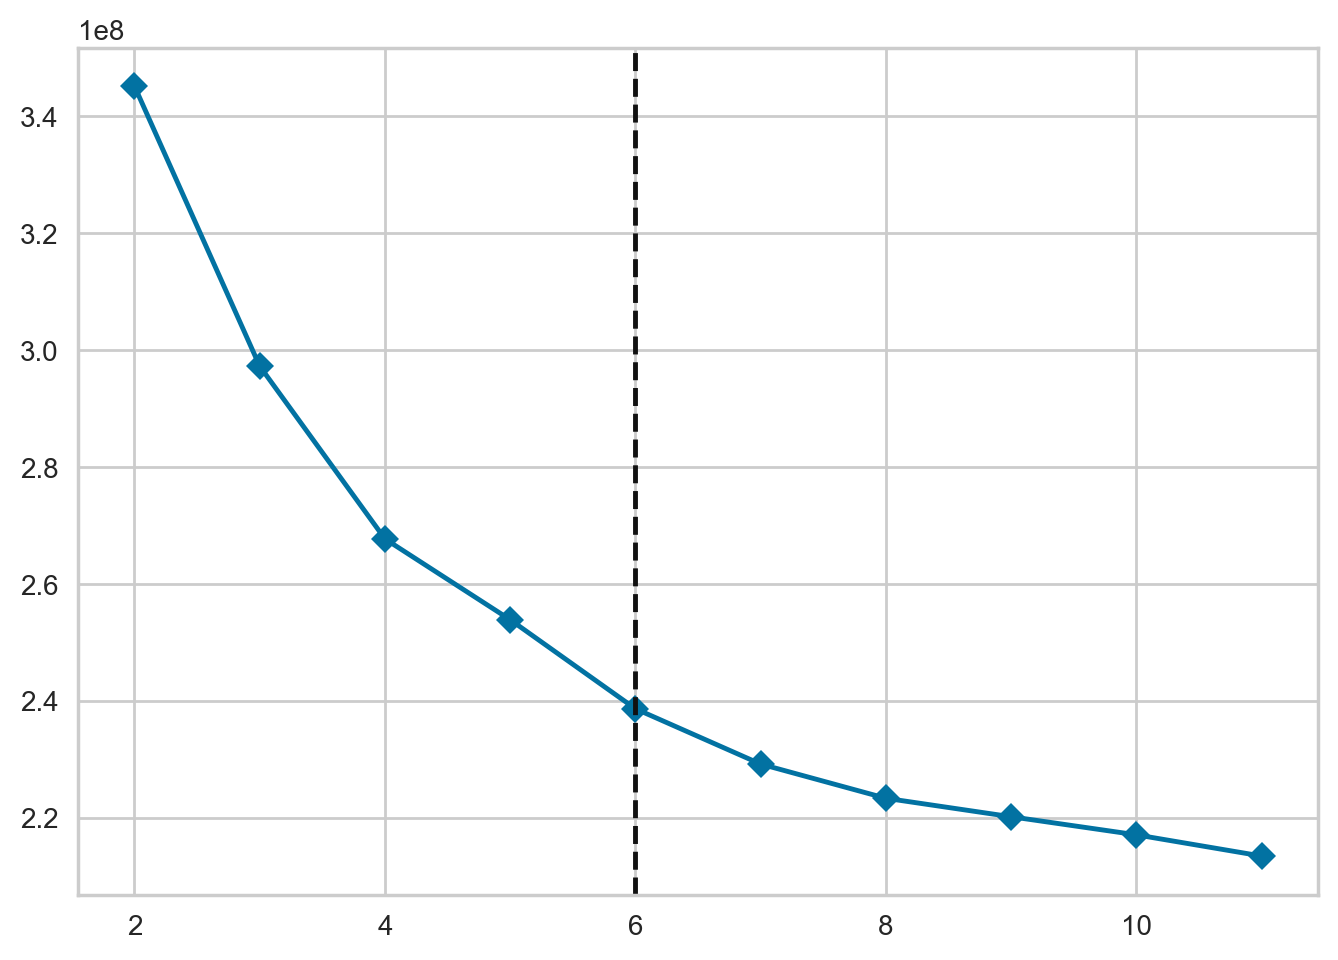

In [25]:
data_scaled_sample = data_scaled.sample(n=500000) # sample for size of data set

# k-means clusterer

KClusterer = KMeans(n_clusters=3, # initialized with 3 for simplicity
                   verbose=0,
                   random_state=2025) # Name of operator and cluster number

# Elbow visualizer

visualizer = KElbowVisualizer(KClusterer,
                              k=(2,12),
                              locate_elbow=True,
                              timings=False)

visualizer.fit(data_scaled_sample)
visualizer.show

## Chosen: 6 clusters

### Silhouette

KeyboardInterrupt: 

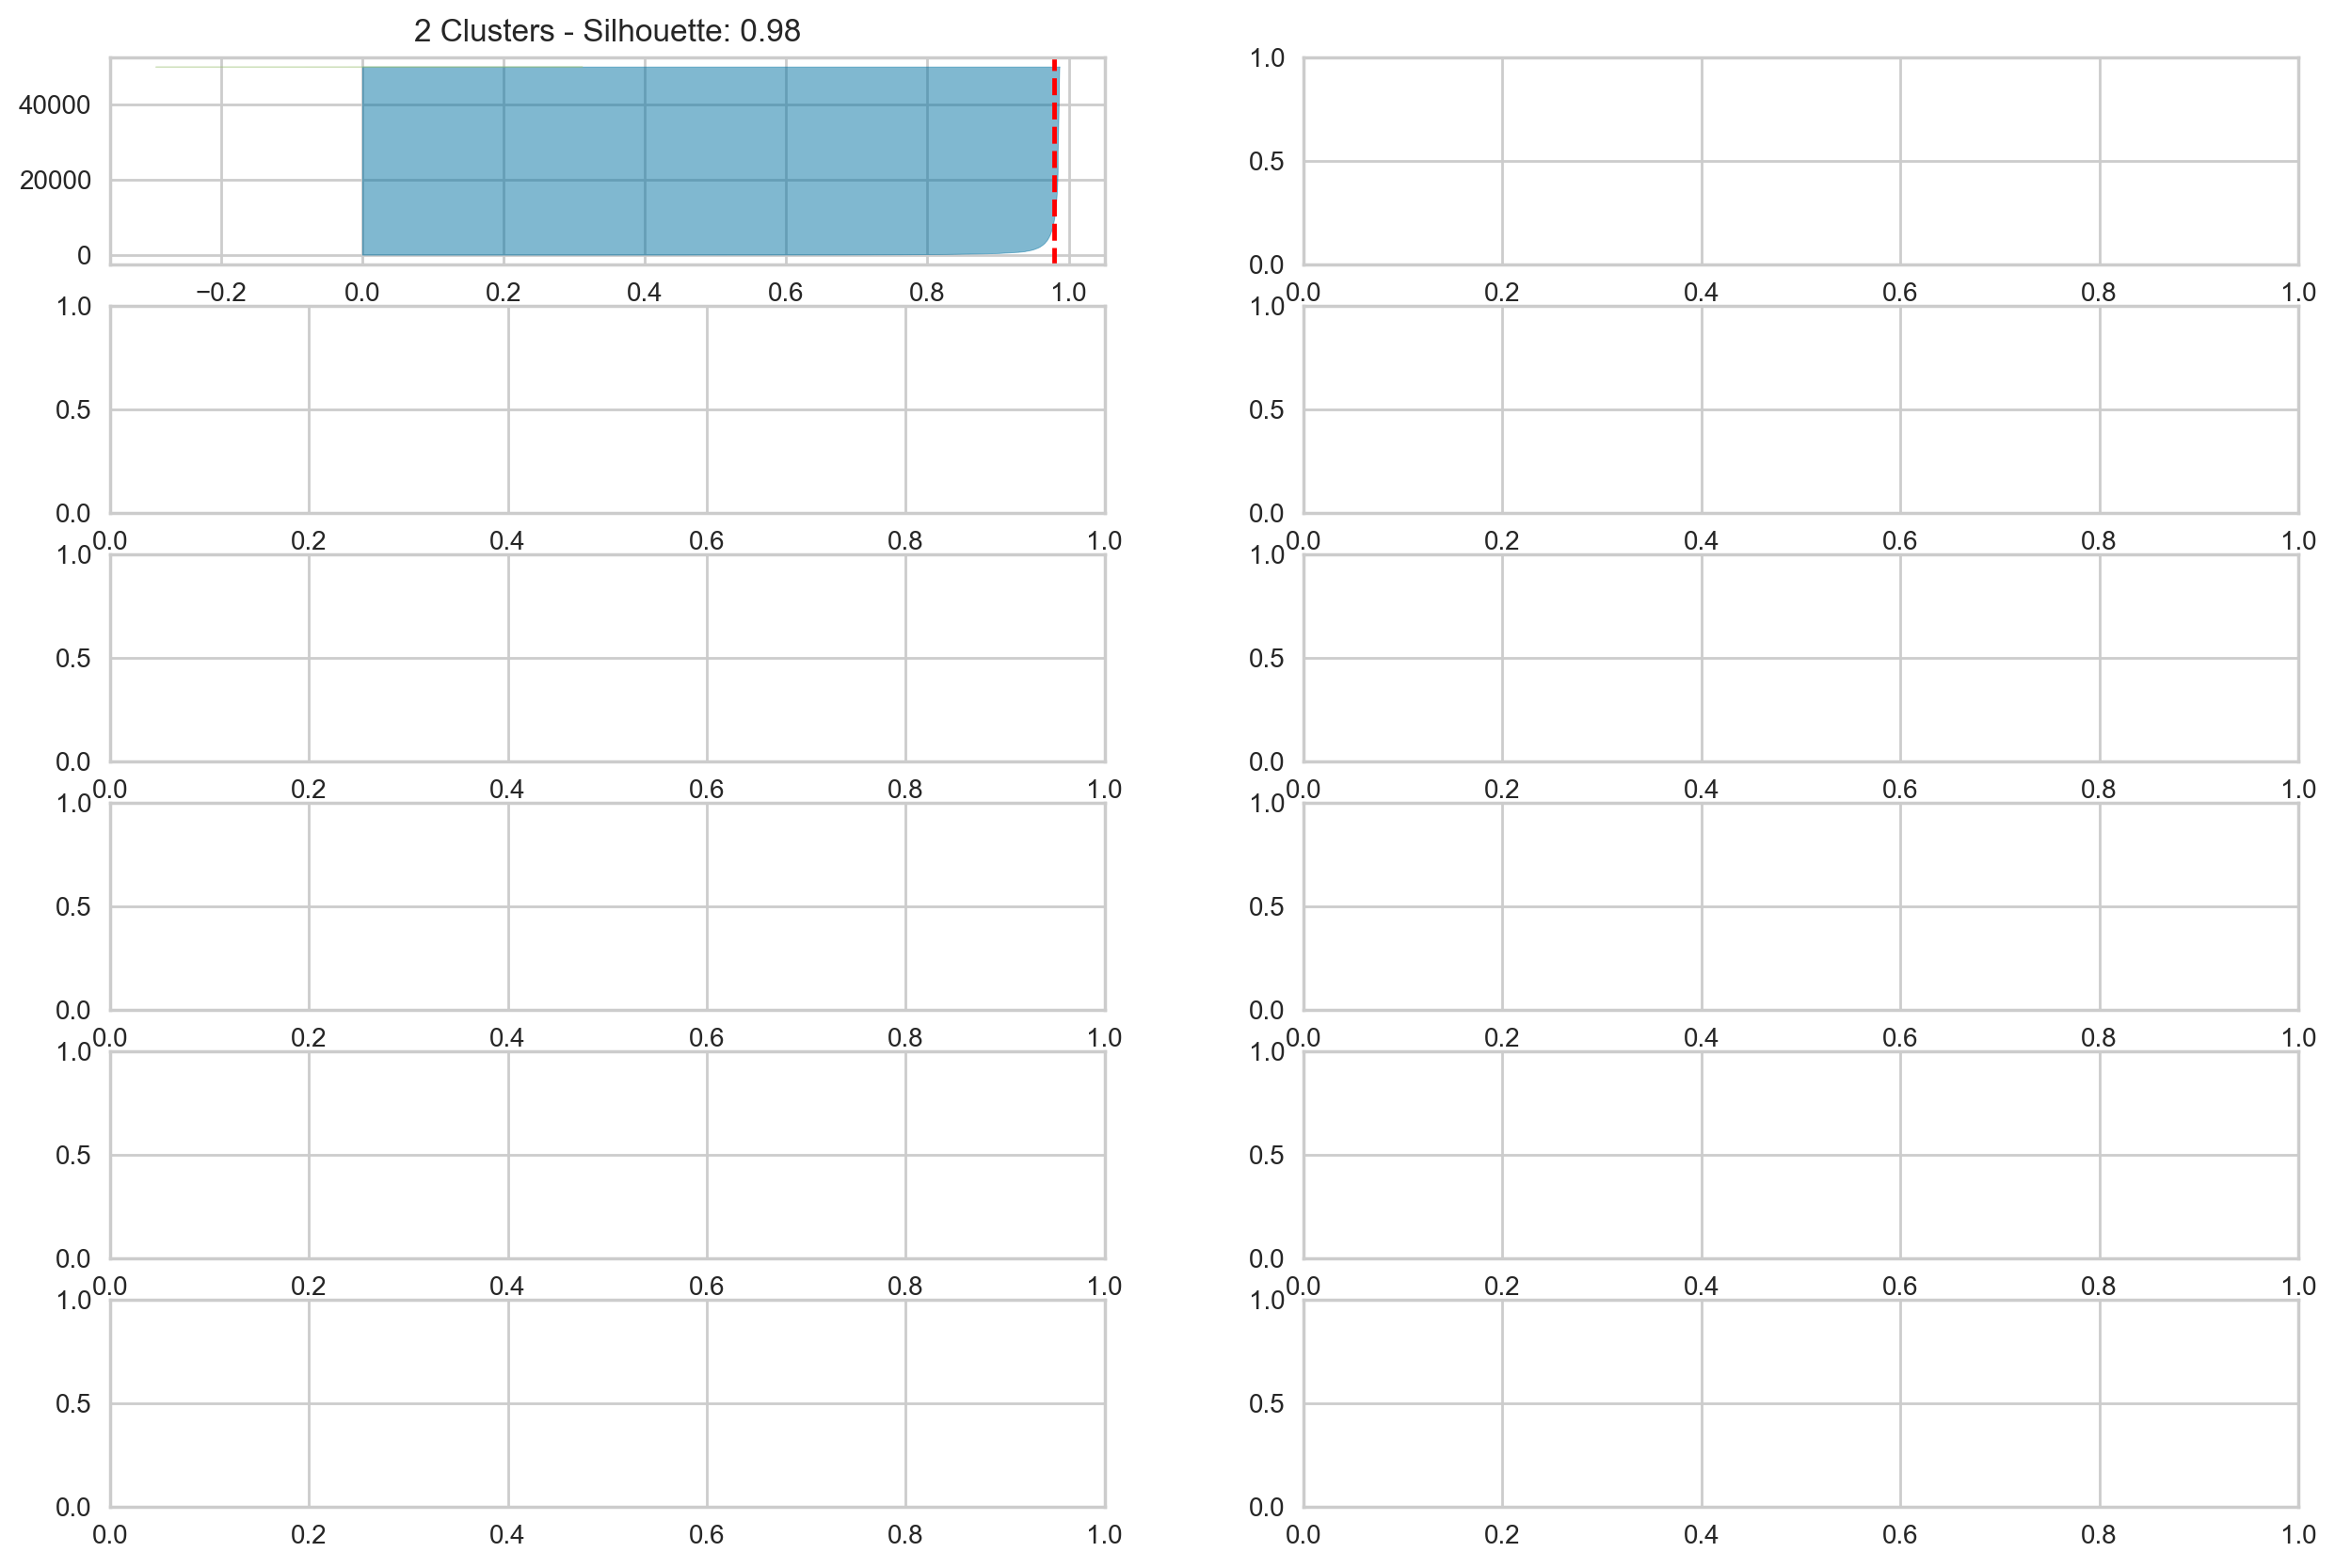

In [28]:
data_scaled_sample = data_scaled.sample(n=50000) # sample for size of data set

# Silhouette visualizer

fig, axes = plt.subplots(6, 2, figsize=(15,10))
axes = axes.flatten()
sil_scores = {}

for i in range(2,12):
    Kmeansclusterer = KMeans(n_clusters=i,
                            verbose=0,
                            random_state=2025,
                            n_init=10)
    cluster_labels = Kmeansclusterer.fit_predict(data_scaled_sample.values)
    sil_avg = silhouette_score(data_scaled_sample.values, cluster_labels, n_jobs = -1)
    sil_scores[f'{i} clusters'] = sil_avg

    visualizer = SilhouetteVisualizer(Kmeansclusterer, colors='yellowbrick', ax=axes[i-2])
    visualizer.fit(data_scaled_sample.values)  # Fit only the scaled data, not cluster labels
    axes[i-2].set_title(f"{i} Clusters - Silhouette: {sil_avg:.2f}")
    
plt.tight_layout()
plt.show()

print("Silhouette Scores:", sil_scores)
max_values = heapq.nlargest(3, sil_scores.values())
max_keys = [key for key, value in sil_scores.items() if value in max_values]
print("The greatest silhouette scores are from ", max_keys, "with scores of", max_values)

### Applying k-means according to best cluster number (data not scaled)

In [ ]:
KClusterer = KMeans(n_clusters=5, # put in optimal cluster amount
                   verbose=0,
                   random_state=2025) # Name of operator and cluster number

data_np = data.to_numpy() # not the scaled version
cluster_labels = KClusterer.fit_predict(data_np)
data_cluster_table = data.with_columns(pl.Series("cluster_label", cluster_labels))

cluster_avg = data_cluster_table.group_by("cluster_label").agg([
    pl.col(column).mean().alias(f"{column}_mean") for column in data_cluster_table.columns if column != "cluster_label"
])
print(cluster_avg.sort('cluster_label'))

## c. Linear dimensionality reductions

### i. Applying PCA

In [ ]:
## PCA
nPCA = PCA(n_components=100)
nPCA.fit(np.asarray(data_scaled.todense()))
total_variance = np.sum(nPCA.explained_variance_) * 100
print('The total explained variance of the first %i components is %.3f percent' % (nPCA.n_components_, total_variance))

### ii. Plot the data of the first two PCs in a scatterplot (scaled data)

In [ ]:
pca_components = nPCA.transform(np.asarray(data_scaled.todense()))
pc1 = pca_components[:, 0]  # First principal component
pc2 = pca_components[:, 1]  # Second principal component
pc3 = pca_components[:, 2]  # Second principal component

cluster_labels_scaled = KClusterer.fit_predict(data_scaled)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    pc1, 
    pc2, 
    c=cluster_labels_scaled, 
    cmap='viridis',  # You can change to 'plasma', 'rainbow', etc.
    alpha=0.6,       # Slightly transparent points
    edgecolors='w',  # White edges for better visibility
    s=50            # Point size
)

plt.xlabel('Principal Component 1 (PC1)', fontsize=12)
plt.ylabel('Principal Component 2 (PC2)', fontsize=12)
plt.title('PCA Scatterplot Colored by Cluster', fontsize=14)

cbar = plt.colorbar(scatter)
cbar.set_label('Cluster Label', fontsize=12)

plt.show()

### iii. Calculate average value of first three components, put into table

In [ ]:
pca_df = pd.DataFrame({
    'PC1': pc1,
    'PC2': pc2,
    'PC3': pc3,
    'Cluster': cluster_labels_scaled  # From KClusterer.fit_predict(data_scaled)
})

cluster_means = pca_df.groupby('Cluster').mean().reset_index()

def name_cluster(row):
    max_pc = max(['PC1', 'PC2', 'PC3'], key=lambda x: abs(row[x]))
    if max_pc == 'PC1':
        return "High PC1 (Topic A)" if row['PC1'] > 0 else "Low PC1 (Topic B)"
    elif max_pc == 'PC2':
        return "High PC2 (Topic C)" if row['PC2'] > 0 else "Low PC2 (Topic D)"
    else:
        return "High PC3 (Topic E)" if row['PC3'] > 0 else "Low PC3 (Topic F)"

cluster_means['Cluster_Name'] = cluster_means.apply(name_cluster, axis=1)
print(cluster_means[['Cluster', 'Cluster_Name', 'PC1', 'PC2', 'PC3']])

## d. UMAP

### Choice of parameters

In [ ]:
# best parameters to use:

# Define parameter grid
param_grid = {
    'n_neighbors': [5, 15, 30, 50],
    'min_dist': [0.01, 0.1, 0.5],
    'metric': ['euclidean', 'cosine']
}

best_score = -1
best_params = {}
best_embedding = None

# Grid search (small-scale for demonstration)
for n in param_grid['n_neighbors']:
    for d in param_grid['min_dist']:
        for m in param_grid['metric']:
            reducer = umap.UMAP(n_neighbors=n, min_dist=d, metric=m, random_state=2025)
            embedding = reducer.fit_transform(np.asarray(data_scaled.todense()))
            score = silhouette_score(embedding, cluster_labels)
            if score > best_score:
                best_score = score
                best_params = {'n_neighbors': n, 'min_dist': d, 'metric': m}
                best_embedding = embedding

print(f"Best parameters: {best_params}, Silhouette score: {best_score:.3f}")

### Plot UMAP

In [ ]:
reducer = umap.UMAP(n_neighbors=10,              # Number of neareast neighbours to use. (set to best)
                    n_components=2,              # Number of components. UMAP is robust to larger values
                    metric='cosine',             # Metric to use. (set to best)
                    n_epochs=1000,               # Iterations. Set to convergence. None implies either 200 or 500.
                    min_dist=0.1,                # Minimum distance embedded points. Smaller makes clumps, larger, sparseness. (set to best)
                    spread=1.0,                  # Scale to combine with min_dist
                    low_memory=False,             # Run slower, but with less memory.
                    n_jobs=-1,                   # Cores to use
                    verbose=0                 # Verbosity
                   )
UMAP_embedding = reducer.fit_transform(data_scaled)

sns.scatterplot(x=UMAP_embedding[:, 0], y=UMAP_embedding[:, 1], hue=cluster_labels_scaled)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("UMAP of data")
plt.show()

# Question 2


## a. Regularized elastic-net linear regression from data